# 1) Importation des librairies

In [1]:
from cProfile import label

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Pour la séparation des données en train/test
from sklearn.model_selection import train_test_split

# Pour la création et l'évaluation de modèles
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

# Pour l'optimisation des hyperparamètres
from sklearn.model_selection import GridSearchCV

# 2) Chargement des données

In [2]:
# Lis les différents fichiers CSV
folder = "src/"
df_general = pd.read_csv(folder + "general_data.csv")
df_emp_survey = pd.read_csv(folder + "employee_survey_data.csv")
df_mgr_survey = pd.read_csv(folder + "manager_survey_data.csv")
df_in_time = pd.read_csv(folder + "in_time.csv")
df_out_time = pd.read_csv(folder + "out_time.csv")

# 3) Exploration des données

In [3]:
print("=== General Data ===")
print(df_general.head(), "\n")
print(df_general.info(), "\n")

print("=== Employee Survey Data ===")
print(df_emp_survey.head(), "\n")
print(df_emp_survey.info(), "\n")

print("=== Manager Survey Data ===")
print(df_mgr_survey.head(), "\n")
print(df_mgr_survey.info(), "\n")

print("=== In Time Data ===")
print(df_in_time.head(), "\n")
print(df_in_time.info(), "\n")

print("=== Out Time Data ===")
print(df_out_time.head(), "\n")
print(df_out_time.info(), "\n")

=== General Data ===
   Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   51        No      Travel_Rarely                   Sales                 6   
1   31       Yes  Travel_Frequently  Research & Development                10   
2   32        No  Travel_Frequently  Research & Development                17   
3   38        No         Non-Travel  Research & Development                 2   
4   32        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeCount  EmployeeID  Gender  ...  \
0          2  Life Sciences              1           1  Female  ...   
1          1  Life Sciences              1           2  Female  ...   
2          4          Other              1           3    Male  ...   
3          5  Life Sciences              1           4    Male  ...   
4          1        Medical              1           5    Male  ...   

   NumCompaniesWorked Over18 PercentSalaryHike  StandardHours  \


 # 4) Fusion des données

## 4.1) Merge general_data, employee_survey_data et manager_survey_data

In [4]:
df_merged = pd.merge(df_general, df_emp_survey, on="EmployeeID")
df_merged = pd.merge(df_merged, df_mgr_survey, on="EmployeeID")

## 4.2) Calculer le nombre d'heures travaillées par jour
On va aussi créer des features à partir de df_in_time et df_out_time (par exemple : nombre d'heures travaillées moyennes). </br>
Les colonnes de in_time / out_time sont des dates/heures pour chaque jour travaillé.

In [5]:
#  - Pour chaque employé, on peut calculer la différence out_time - in_time (en heures) pour chaque jour.
#  - Ensuite on peut faire la moyenne sur toutes les dates disponibles pour obtenir "moyenne d'heures/jour"

# Replace Unnamed header by EmployeeID
df_in_time.rename(columns={"Unnamed: 0": "EmployeeID"}, inplace=True)
df_out_time.rename(columns={"Unnamed: 0": "EmployeeID"}, inplace=True)

# Suppression de la première colonne "EmployeeID" pour faciliter les opérations (on la conserve à part)
df_in_time_id = df_in_time['EmployeeID']
df_out_time_id = df_out_time['EmployeeID']

# On exclut la colonne 'EmployeeID' des dataframes pour ne traiter que les colonnes date/heure
df_in_time_dates = df_in_time.drop(['EmployeeID'], axis=1)
df_out_time_dates = df_out_time.drop(['EmployeeID'], axis=1)

# Conversion des valeurs string en datetime pour permettre la soustraction des temps
# Nota : Certaines valeurs sont "NA" => conversion en NaT
df_in_time_dates = df_in_time_dates.apply(pd.to_datetime, errors='coerce')
df_out_time_dates = df_out_time_dates.apply(pd.to_datetime, errors='coerce')

# Calcul de la différence (out_time - in_time) par employé et par jour
df_hours = df_out_time_dates - df_in_time_dates  # Résultat en format timedelta

# Convertir les timedelta en nombre d'heures (float)
df_hours = df_hours.apply(lambda x: x.dt.total_seconds() / 3600)

# Exemple : Calcul d'une statistique agrégée (moyenne d'heures/jour travaillé) pour chaque employé
df_hours['mean_work_hours'] = df_hours.mean(axis=1)

# On peut aussi calculer le nombre de jours d'absence (journées entières manquantes => in_time = NA & out_time = NA)
# ou le ratio de jours travaillés vs le total possible, etc.
# Ci-dessous un exemple de calcul du nombre de jours (colonnes) pour lesquels l'entrée est manquante
nb_jours_total = df_hours.shape[1] - 1  # -1 car la dernière colonne est 'mean_work_hours' qu'on vient d'ajouter
df_hours['absent_days'] = df_hours.iloc[:, :-1].isna().sum(axis=1)  # On ne compte pas la col. 'mean_work_hours'

# Concaténer EmployeeID pour pouvoir refusionner
df_hours_final = pd.concat([df_in_time_id, df_hours[['mean_work_hours','absent_days']]], axis=1)

## 4.3) Merge avec df_merged pour rajouter ces nouvelles features

In [6]:
df_merged = pd.merge(df_merged, df_hours_final, on='EmployeeID', how='left')

print("\n=== Aperçu des données fusionnées ===\n")
print(df_merged.head())
print(df_merged.info())


=== Aperçu des données fusionnées ===

   Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   51        No      Travel_Rarely                   Sales                 6   
1   31       Yes  Travel_Frequently  Research & Development                10   
2   32        No  Travel_Frequently  Research & Development                17   
3   38        No         Non-Travel  Research & Development                 2   
4   32        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeCount  EmployeeID  Gender  ...  \
0          2  Life Sciences              1           1  Female  ...   
1          1  Life Sciences              1           2  Female  ...   
2          4          Other              1           3    Male  ...   
3          5  Life Sciences              1           4    Male  ...   
4          1        Medical              1           5    Male  ...   

   YearsAtCompany YearsSinceLastPromotion Year

# Analyse de la distribution normale des données

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

def plot_normal_distribution(df, column_name, log_transform=False, log_base='10'):
    """
    Trace un histogramme (densité) de la colonne `column_name` d'un DataFrame `df`
    et superpose la courbe de la distribution normale basée sur la moyenne et
    l'écart-type (sur données brutes ou log-transformées).

    Paramètres:
    -----------
    df : pd.DataFrame
        Votre DataFrame
    column_name : str
        Nom de la colonne à tracer
    log_transform : bool
        Si True, applique un log sur les valeurs de la colonne avant le tracé.
    log_base : str
        - '10' pour un log base 10 (log10)
        - 'e' pour un log naturel (ln)
    """
    data = df[column_name].dropna()

    if log_transform:
        if log_base == '10':
            data = np.log10(data + 1)
            suffix = " (log10)"
        elif log_base == 'e':
            data = np.log(data + 1)
            suffix = " (ln)"
        else:
            raise ValueError("log_base doit être '10' ou 'e'")
    else:
        suffix = ""


    mean = data.mean()
    std = data.std()

    x_min = mean - 3 * std
    x_max = mean + 3 * std

    if x_min == x_max:
        x_min = mean - 1
        x_max = mean + 1

    x = np.linspace(x_min, x_max, 200)

    pdf = norm.pdf(x, mean, std)
    plt.figure(figsize=(8, 6))
    sns.histplot(data, kde=False, stat='density', bins=30, color='skyblue', label='Données')

    plt.plot(x, pdf, color='red', linewidth=2, label='Distribution normale')
    plt.xlim(x_min, x_max)

    plt.title(f"Distribution de la colonne: {column_name}{suffix}")
    plt.xlabel(f"{column_name}{suffix}")
    plt.ylabel("Densité")
    plt.legend()

    plt.show()


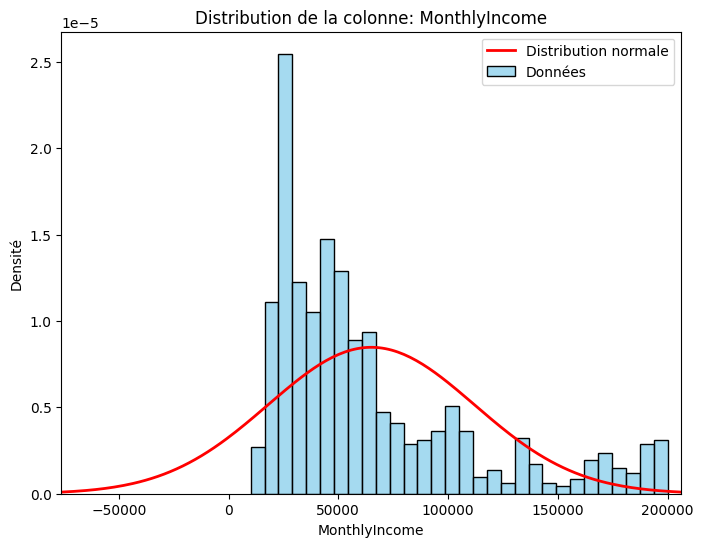

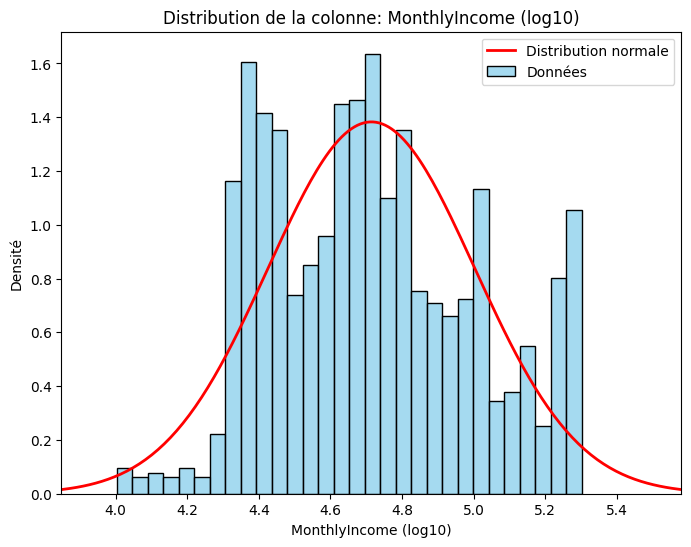

In [28]:
plot_normal_distribution(df_merged, 'MonthlyIncome', log_transform=False)
plot_normal_distribution(df_merged, 'MonthlyIncome', log_transform=True, log_base='10')

# 5) Nettoyage et préparation des données

## 5.1) Gérer les valeurs manquantes

In [ ]:
# On regarde déjà combien de valeurs manquantes par colonne
missing_values = df_merged.isnull().sum()
print("\n=== Nombre de valeurs manquantes par colonne ===\n", missing_values)


=== Nombre de valeurs manquantes par colonne ===
 Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
JobInvolvement              0
PerformanceRating           0
mean_work_hours             0
absent_days                 0
dtype: int64


In [ ]:
# Dropna sur la colonne Attrition car c'est notre target
df_merged = df_merged.dropna(subset=['Attrition'])

In [ ]:
# Exemple d'imputation : pour 'mean_work_hours' et 'absent_days', on remplace les NaN par la moyenne
# On privilégie la moyenne ici car les valeurs de type durée (heures) ne sont pas fortement bornées
df_merged['mean_work_hours'] = df_merged['mean_work_hours'].fillna(df_merged['mean_work_hours'].mean())
print(f"Filled missing values for column 'mean_work_hours' with mean value {df_merged['mean_work_hours'].mean()}")
df_merged['absent_days'] = df_merged['absent_days'].fillna(df_merged['absent_days'].mean())
print(f"Filled missing values for column 'absent_days' with mean value {df_merged['absent_days'].mean()}")

Filled missing values for column 'mean_work_hours' with mean value 7.700791784478147
Filled missing values for column 'absent_days' with mean value 24.73469387755102


In [ ]:
# Pour les colonnes de satisfaction ou autres colonnes numériques manquantes, on peut aussi faire un fillna
# On privilégie la médiane
num_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
            'JobInvolvement', 'PerformanceRating', 'TotalWorkingYears', 'NumCompaniesWorked',]
for col in num_cols:
    if col in df_merged.columns:
        df_merged[col] = df_merged[col].fillna(df_merged[col].median())
        print(f"Filled missing values for column {col} with median value {df_merged[col].median()}")


Filled missing values for column EnvironmentSatisfaction with median value 3.0
Filled missing values for column JobSatisfaction with median value 3.0
Filled missing values for column WorkLifeBalance with median value 3.0
Filled missing values for column JobInvolvement with median value 3.0
Filled missing values for column PerformanceRating with median value 3.0
Filled missing values for column TotalWorkingYears with median value 10.0
Filled missing values for column NumCompaniesWorked with median value 2.0


## 5.2) Nettoyage de certaines colonnes (ex: Over18, EmployeeCount, StandardHours)

In [ ]:
# On remarque souvent dans ce dataset "EmployeeCount" est toujours 1 => pas d'intérêt
# "Over18" est toujours "Y", "StandardHours" est souvent 8 => on peut les drop
cols_to_drop = ['Over18','StandardHours','EmployeeCount']
for c in cols_to_drop:
    if c in df_merged.columns:
        df_merged.drop(c, axis=1, inplace=True, errors='ignore')

## 5.3) Conversion de colonnes catégorielles en numériques

In [ ]:
# Par exemple, Attrition = Yes/No, Gender = Male/Female, etc.
# On peut les encoder, soit via LabelEncoder, soit via OneHotEncoder
# Commençons par un label encoding simple pour la variable cible

df_merged['Attrition'] = df_merged['Attrition'].map({'Yes':1, 'No':0})

# Autres colonnes catégorielles (BusinessTravel, Department, EducationField, Gender, MaritalStatus, JobRole...)
cat_cols = ['BusinessTravel','Department','EducationField','Gender','MaritalStatus','JobRole']

# On va faire un one-hot-encoding rapide:
df_merged = pd.get_dummies(df_merged, columns=cat_cols, drop_first=True)

# 6) Séparation des données en train/test

In [ ]:
# On sépare la cible (Attrition) des features

X = df_merged.drop(['EmployeeID','Attrition'], axis=1)
y = df_merged['Attrition']

# Ensuite on fait un split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 7) scaling et entraînement d'un modèle simple

In [ ]:
# Selon le modèle (Logistic Regression par exemple), il peut être intéressant de standardiser
# Ici on va montrer un exemple de pipeline manuel (scaling + logistic regression).

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 7.1) Entrainement d'un modèle de Logistic Regression

In [ ]:
clf_lr = LogisticRegression(random_state=42, max_iter=500)
clf_lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500, random_state=42)

## 7.2) Prediction et évaluation

### 7.2.1) Prediction

In [ ]:
y_pred_lr = clf_lr.predict(X_test_scaled)
y_proba_lr = clf_lr.predict_proba(X_test_scaled)[:,1]

### 7.2.2) Evaluation

In [ ]:
# Évaluation
print("=== Évaluation Logistic Regression ===")
print("Accuracy : ", accuracy_score(y_test, y_pred_lr))
print("ROC AUC  : ", roc_auc_score(y_test, y_proba_lr))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_lr))
print("Classification report :\n", classification_report(y_test, y_pred_lr))

=== Évaluation Logistic Regression ===
Accuracy :  0.8571428571428571
ROC AUC  :  0.8034640274076894
Matrice de confusion :
 [[1077   33]
 [ 156   57]]
Classification report :
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1110
           1       0.63      0.27      0.38       213

    accuracy                           0.86      1323
   macro avg       0.75      0.62      0.65      1323
weighted avg       0.83      0.86      0.83      1323



## 7.3) Entrainement d'un modèle de Random Forest

In [ ]:
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train, y_train)  # On peut le tester sans scaling
y_pred_rf = clf_rf.predict(X_test)
y_proba_rf = clf_rf.predict_proba(X_test)[:,1]

print("\n=== Évaluation Random Forest ===")
print("Accuracy : ", accuracy_score(y_test, y_pred_rf))
print("ROC AUC  : ", roc_auc_score(y_test, y_proba_rf))
print("Legende de la matrice de confusion :")
print("TN FP")
print("FN TP")
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_rf))
print("Classification report :\n", classification_report(y_test, y_pred_rf))


=== Évaluation Random Forest ===
Accuracy :  0.983371126228269
ROC AUC  :  0.9859662479380789
Legende de la matrice de confusion :
TN FP
FN TP
Matrice de confusion :
 [[1107    3]
 [  19  194]]
Classification report :
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1110
           1       0.98      0.91      0.95       213

    accuracy                           0.98      1323
   macro avg       0.98      0.95      0.97      1323
weighted avg       0.98      0.98      0.98      1323



# 8) Optimisation des hyperparamètres

## 8.1) Tuning de la Logistic Regression

In [ ]:
# Exemple de grille de paramètres (simple).
# Attention : certaines combinaisons penalty/solver peuvent être incompatibles.
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],         # Coefficient de régularisation
    'solver': ['liblinear', 'lbfgs'],     # Solveur
    'max_iter': [100, 200, 500]           # Nombre itérations max
    # 'penalty': ['l1','l2']  # <--- l1 nécessite solver='liblinear';
                              #      si on veut tester l1, il faut ajuster la grille
}

# Création de l'instance LogisticRegression
lr_model = LogisticRegression(random_state=42)

# GridSearchCV : 5-fold cross-validation, scoring basé sur l'accuracy (ou 'roc_auc', etc.)
grid_lr = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid_lr,
    scoring='accuracy',        # ou 'roc_auc'
    cv=5,                      # 5 folds
    verbose=1,                 # pour voir la progression
    n_jobs=-1                  # utilise tous les coeurs dispo
)

# Entraînement du GridSearchCV
grid_lr.fit(X_train_scaled, y_train)

# Récupération des meilleurs paramètres et score
print("=== Logistic Regression - Meilleurs hyperparamètres ===")
print("Best Params :", grid_lr.best_params_)
print("Best Score  :", grid_lr.best_score_)

# On peut maintenant re-prédire sur le test set avec le meilleur modèle trouvé
best_lr = grid_lr.best_estimator_
y_pred_best_lr = best_lr.predict(X_test_scaled)
y_proba_best_lr = best_lr.predict_proba(X_test_scaled)[:,1]

print("\n=== Évaluation sur le jeu de test (LogisticRegression avec meilleurs params) ===")
print("Accuracy :", accuracy_score(y_test, y_pred_best_lr))
print("ROC AUC  :", roc_auc_score(y_test, y_proba_best_lr))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_best_lr))
print("Classification report :\n", classification_report(y_test, y_pred_best_lr))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
=== Logistic Regression - Meilleurs hyperparamètres ===
Best Params : {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'}
Best Score  : 0.8564942592038939

=== Évaluation sur le jeu de test (LogisticRegression avec meilleurs params) ===
Accuracy : 0.854119425547997
ROC AUC  : 0.8019202300892442
Matrice de confusion :
 [[1077   33]
 [ 160   53]]
Classification report :
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1110
           1       0.62      0.25      0.35       213

    accuracy                           0.85      1323
   macro avg       0.74      0.61      0.64      1323
weighted avg       0.83      0.85      0.83      1323



### 8.1.1) Visualisation des résultats

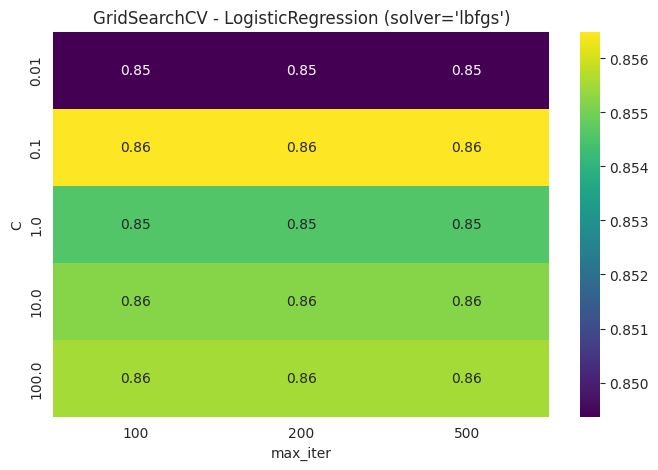

In [ ]:
# Exemple : on peut faire un DataFrame à partir de grid_lr.cv_results_ pour tracer un heatmap
# entre C et max_iter, en séparant par solver.
# Cela nécessite un pivot de la table.

results_lr = pd.DataFrame(grid_lr.cv_results_)

# Pour simplifier, on ne visualise que le solver='lbfgs', par exemple
df_lbfgs = results_lr[ results_lr['param_solver'] == 'lbfgs' ]
# Pivot => index: param_C, columns: param_max_iter, values: mean_test_score
pivot_lbfgs = df_lbfgs.pivot(
    index='param_C',
    columns='param_max_iter',
    values='mean_test_score'
)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_lbfgs, annot=True, cmap='viridis')
plt.title("GridSearchCV - LogisticRegression (solver='lbfgs')")
plt.ylabel("C")
plt.xlabel("max_iter")
plt.show()

## 8.2) Tuning du Random Forest

In [ ]:
# Exemple de grille de paramètres
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
    # on peut rajouter 'max_features', 'min_samples_leaf', etc. selon les besoins
}

# l'objectif du random_state est de garantir la reproductibilité des résultats. La valeur 42 est arbitraire.
rf_model = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring='accuracy',  # ou 'roc_auc'
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
print("\n=== Random Forest - Meilleurs hyperparamètres ===")
print("Best Params :", grid_rf.best_params_)
print("Best Score  :", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
y_proba_best_rf = best_rf.predict_proba(X_test)[:,1]

print("\n=== Évaluation sur le jeu de test (RandomForest avec meilleurs params) ===")
print("Accuracy :", accuracy_score(y_test, y_pred_best_rf))
print("ROC AUC  :", roc_auc_score(y_test, y_proba_best_rf))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_best_rf))
print("Classification report :\n", classification_report(y_test, y_pred_best_rf))

Fitting 5 folds for each of 36 candidates, totalling 180 fits

=== Random Forest - Meilleurs hyperparamètres ===
Best Params : {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Score  : 0.9682596130142196

=== Évaluation sur le jeu de test (RandomForest avec meilleurs params) ===
Accuracy : 0.9803476946334089
ROC AUC  : 0.98737046906061
Matrice de confusion :
 [[1104    6]
 [  20  193]]
Classification report :
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1110
           1       0.97      0.91      0.94       213

    accuracy                           0.98      1323
   macro avg       0.98      0.95      0.96      1323
weighted avg       0.98      0.98      0.98      1323



### 8.2.1) Visualisation des résultats

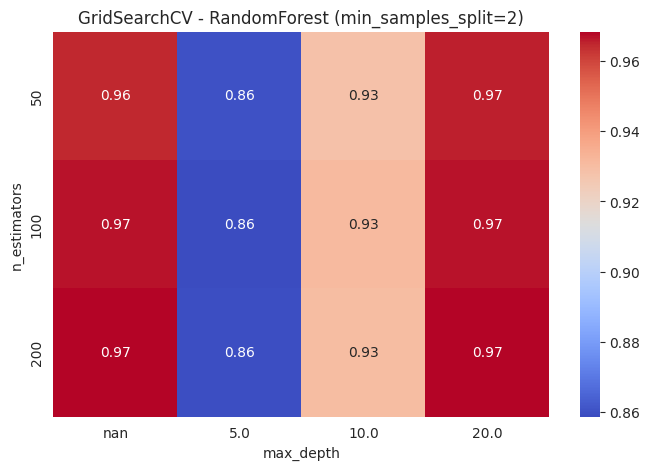

In [ ]:
results_rf = pd.DataFrame(grid_rf.cv_results_)

# Exemple d'extraction de la partie n_estimators / max_depth (pivot sur 2 variables)
# On fixe min_samples_split=2 par exemple pour la visualisation
df_split2 = results_rf[ results_rf['param_min_samples_split'] == 2 ]

pivot_rf = df_split2.pivot(
    index='param_n_estimators',
    columns='param_max_depth',
    values='mean_test_score'
)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_rf, annot=True, cmap='coolwarm')
plt.title("GridSearchCV - RandomForest (min_samples_split=2)")
plt.ylabel("n_estimators")
plt.xlabel("max_depth")
plt.show()

# 9) Feature importance

## 8.1) Random Forest


=== Feature importances (RandomForest) ===
 mean_work_hours            0.105064
Age                        0.082529
TotalWorkingYears          0.073149
MonthlyIncome              0.068133
YearsAtCompany             0.053926
DistanceFromHome           0.044602
PercentSalaryHike          0.041324
NumCompaniesWorked         0.040350
YearsWithCurrManager       0.039854
EnvironmentSatisfaction    0.034673
dtype: float64


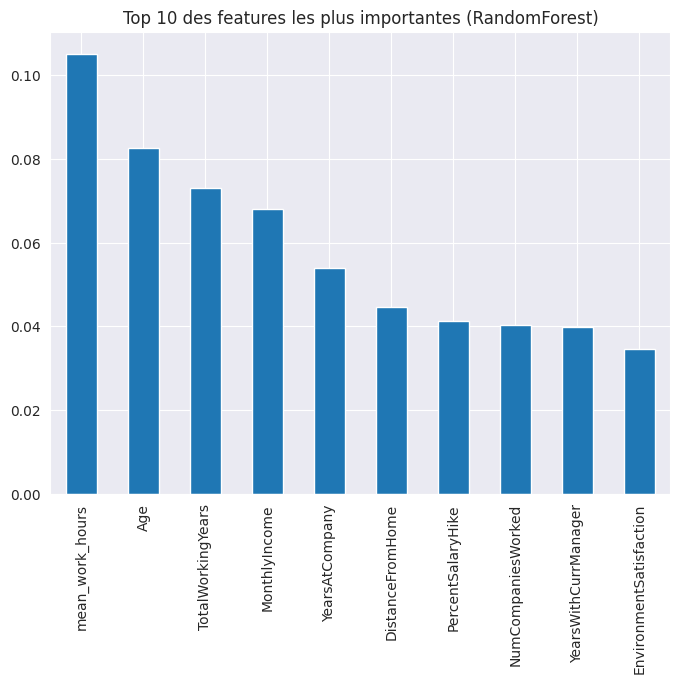

In [ ]:
# Par exemple, on peut rapidement regarder l'importance des features dans le Random Forest :
importances = clf_rf.feature_importances_
feature_names = X_train.columns
feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\n=== Feature importances (RandomForest) ===\n", feat_importances.head(10))

# On peut éventuellement tracer un barplot pour visualiser
plt.figure(figsize=(8,6))
feat_importances.head(10).plot(kind='bar')
plt.title("Top 10 des features les plus importantes (RandomForest)")
plt.show()


## 8.2) Logistic Regression


=== Coefficients (Logistic Regression) ===
 mean_work_hours                     0.633832
MaritalStatus_Single                0.560789
YearsSinceLastPromotion             0.536086
BusinessTravel_Travel_Frequently    0.535345
NumCompaniesWorked                  0.354722
BusinessTravel_Travel_Rarely        0.251936
JobRole_Sales Executive             0.177061
YearsAtCompany                      0.074752
MaritalStatus_Married               0.057218
JobRole_Research Scientist          0.049498
dtype: float64


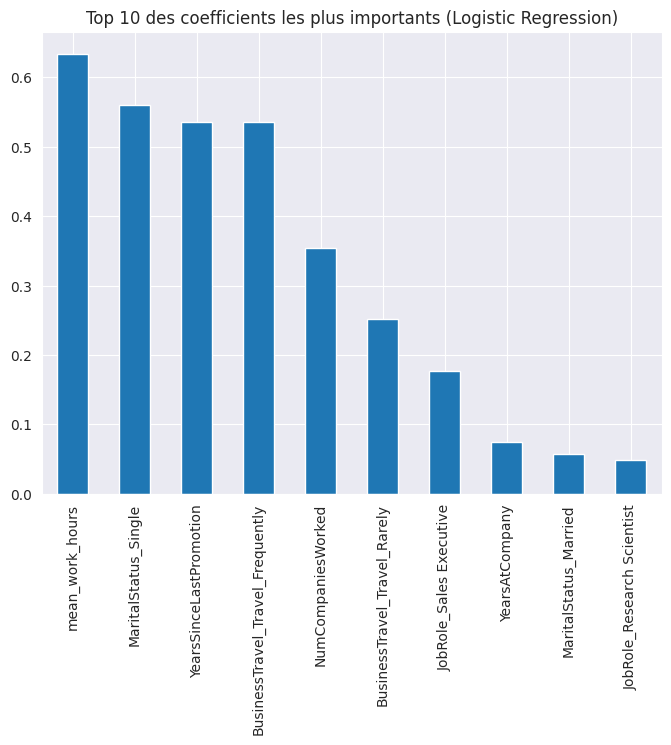

In [ ]:
# Pour la régression logistique, on peut regarder les coefficients associés à chaque feature
# On peut aussi regarder les coefficients les plus importants
coefs = clf_lr.coef_[0]
feat_coefs = pd.Series(coefs, index=feature_names).sort_values(ascending=False)
print("\n=== Coefficients (Logistic Regression) ===\n", feat_coefs.head(10))

# On peut aussi tracer un barplot pour visualiser
plt.figure(figsize=(8,6))
feat_coefs.head(10).plot(kind='bar')
plt.title("Top 10 des coefficients les plus importants (Logistic Regression)")
plt.show()

# 10) Evaluation finale

## 10.1) Train et test scores

In [ ]:
# On peut regarder les scores finaux sur le jeu de train et de test
print("\n=== Scores finaux ===")
print("Accuracy (Train) : ", accuracy_score(y_train, best_rf.predict(X_train)))
print("Accuracy (Test)  : ", accuracy_score(y_test, y_pred_best_rf))
print("ROC AUC  (Train) : ", roc_auc_score(y_train, best_rf.predict_proba(X_train)[:,1]))
print("ROC AUC  (Test)  : ", roc_auc_score(y_test, y_proba_best_rf))


=== Scores finaux ===
Accuracy (Train) :  1.0
Accuracy (Test)  :  0.9803476946334089
ROC AUC  (Train) :  1.0
ROC AUC  (Test)  :  0.98737046906061


## 10.2) Courbe ROC

Nous pouvons constater que la courbe ROC a de bonnes performances pour le modèle Random Forest.

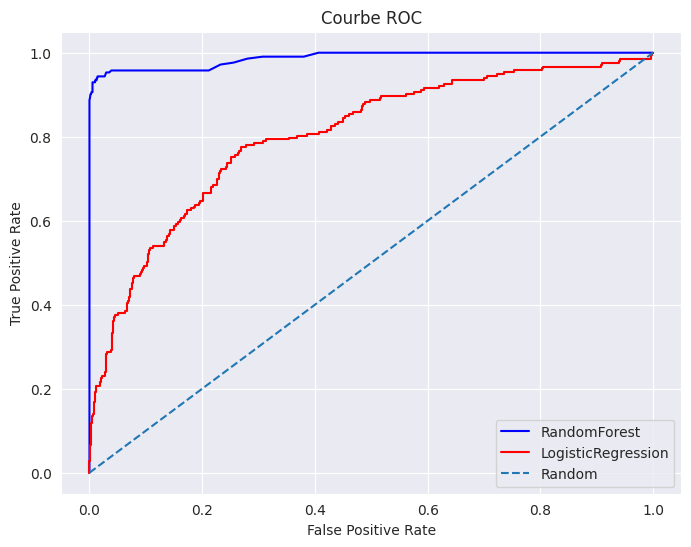

In [ ]:
# On peut aussi tracer la courbe ROC
from sklearn.metrics import roc_curve

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_best_rf)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_proba_best_lr)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label='RandomForest', c='b')
plt.plot(fpr_lr, tpr_lr, label='LogisticRegression', c='r')
plt.plot([0,1], [0,1], '--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC')

plt.legend()
plt.show()
